In [1]:
#pip install pandas numpy scikit-learn matplotlib yfinance tensorflow[and-cuda] scikeras keras_tuner

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import keras_tuner as kt
from keras_tuner import HyperModel, Hyperband

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow import keras

from graphing import graph_normal, show_results
from get_data import addRSI, addATR

2025-04-03 21:01:16.948798: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 21:01:18.905986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743710479.553793   31283 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743710479.727065   31283 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743710481.292164   31283 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
timesteps = 20

# Download Apple stock data
data = yf.download("AAPL", start="2014-01-01", end="2024-01-01")

# Calculate moving averages and relative price change
data['SMA_10'] = data['Close'].rolling(window=10).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# Set target as next difference in price
data['Target'] = data['Close'].shift(-1)

# add RSI
data = addRSI(data)

#add atr
data = addATR(data)

# Add day of the week as an integer (Monday=0, ..., Friday=4)
data['Day_of_Week'] = data.index.dayofweek

# Drop rows with missing values
data.dropna(inplace=True)

# Features
X = data[['SMA_10', 'SMA_50', 'High', 'Close', 'Open', 'Low', 'RSI', 'ATR', 'Day_of_Week']].values
# Target
Y = data[['Target']].values

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

# Reshape for LSTM input
X_reshaped = []
Y_reshaped = []

for i in range(timesteps, len(X_scaled)):
    X_reshaped.append(X_scaled[i - timesteps:i])  # Previous 'timesteps' days
    Y_reshaped.append(Y_scaled[i])  # Target of the current day

X_reshaped = np.array(X_reshaped)
Y_reshaped = np.array(Y_reshaped)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.2, random_state=42)
print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Training samples: 1956, Testing samples: 490


In [4]:
print(X_train.shape)
print(X_train[:,:1])
print(y_train[:,:1])


(1956, 20, 9)
[[[0.03214696 0.03022332 0.03356568 ... 0.49579024 0.04845257 0.25      ]]

 [[0.06713715 0.07181358 0.07409368 ... 0.63061257 0.05042739 0.25      ]]

 [[0.40751776 0.37718216 0.42016355 ... 0.7138441  0.29703154 0.5       ]]

 ...

 [[0.20511549 0.18748034 0.20456068 ... 0.58306893 0.10243962 1.        ]]

 [[0.18599023 0.17394277 0.1851102  ... 0.64673486 0.1291262  0.        ]]

 [[0.11231682 0.10842933 0.1142917  ... 0.60738861 0.08871386 1.        ]]]
[[-0.94038168]
 [-0.89273779]
 [ 0.04752179]
 ...
 [-0.59082673]
 [-0.69368188]
 [-0.7626228 ]]


In [5]:
#repeatable way to create the model 
def create_lstm(hp):
    model = keras.Sequential([
        keras.layers.LSTM(
            units=hp.Int('units_1', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation_1', ['relu', 'tanh', 'sigmoid']),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        ),
        keras.layers.LSTM(
            units=hp.Int('units_2', min_value=32, max_value=256, step=32),
            activation=hp.Choice('activation_2', ['relu', 'tanh', 'sigmoid']),
            return_sequences=False  # Last LSTM layer outputs a single vector
        ),
        keras.layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', [0.001, 0.01, 0.0001])),
        loss='mse', metrics=['mae'])
    
    return model

In [6]:
tuner = kt.RandomSearch(
    create_lstm,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='time_series_ann'
)
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Trial 10 Complete [00h 16m 40s]
val_mae: 0.02028992399573326

Best val_mae So Far: 0.017042294144630432
Total elapsed time: 00h 33m 18s


In [7]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'units_1': 96, 'activation_1': 'relu', 'units_2': 64, 'activation_2': 'relu', 'learning_rate': 0.01}


/mnt/c/Users/kenan/dev/university_final_year_project/venv_linux/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Final Model MAE: 0.0170422958088815
Final Model RMSE: 0.026524710336269474


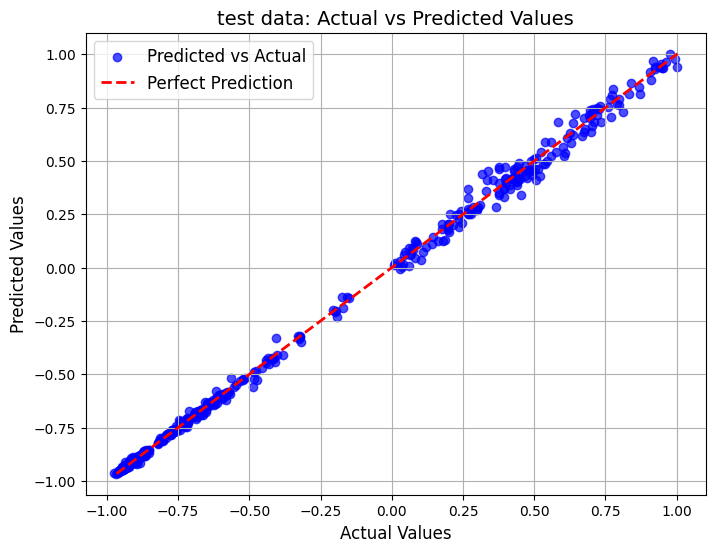

test data  MAE: 0.0170422958088815
test data  RMSE: 0.026524710336269474


In [8]:
# Get the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

predictions = best_model.predict(X_test).flatten()

results = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': predictions
})

# Evaluate the final model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Final Model MAE: {mae}")
print(f"Final Model RMSE: {rmse}")

graph_normal(predictions, y_test, "test data")

In [9]:
from results import get_num_correct_direction

get_num_correct_direction(predictions, y_test.flatten())

489 correct directions out of a total: 490


In [10]:
predictions_original = scaler_Y.inverse_transform(predictions.reshape(-1, 1)).flatten()

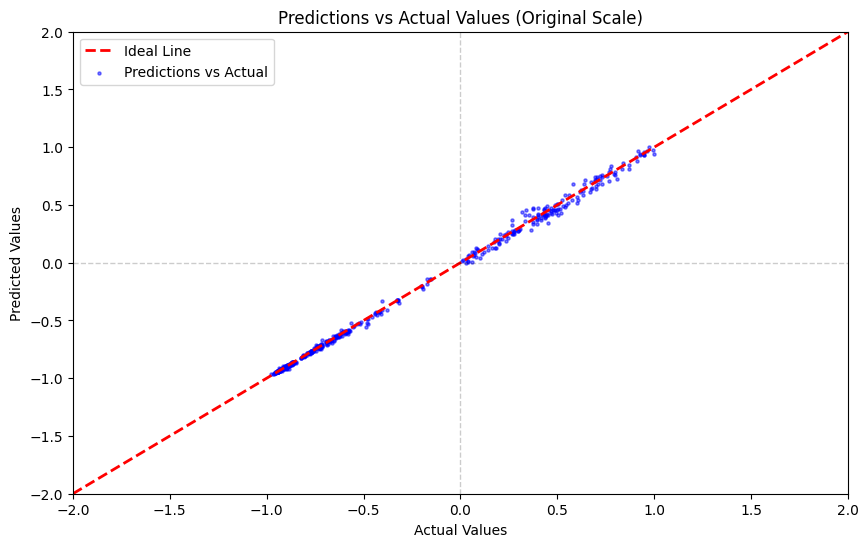

In [17]:
predictions_original = scaler_Y.inverse_transform(predictions.reshape(-1, 1)).flatten()

y_test_original = scaler_Y.inverse_transform(y_test.reshape(-1, 1)).flatten()

plt.figure(figsize=(10, 6))
plt.plot([-2, 2], [-2, 2], color='red', linestyle='--', linewidth=2, label='Ideal Line')
plt.scatter(y_test, predictions, color='blue', alpha=0.5, label='Predictions vs Actual', s =5)
# Adding lines at y = 0 and x = 0
plt.axhline(0, color='black', linestyle='--',alpha=0.2, linewidth=1)  # Horizontal line at y = 0
plt.axvline(0, color='black', linestyle='--',alpha=0.2, linewidth=1)  # Vertical line at x = 0

# Labels and title
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values (Original Scale)')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.legend()

# Show the plot
plt.show()